In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt
import folium
import matplotlib
import matplotlib.ticker as mticker
from scipy.stats import linregress
from matplotlib.font_manager import FontProperties

# Create a FontProperties object with bold font weight
bold_font = FontProperties(weight='bold')



## Plot all included sites

In [25]:
sntls = pd.read_csv('/home/cdalden/summa_setup/analysis/sntl_list_ski_temps.csv', index_col=0)


In [26]:
# Normalize the 'elev' column for color mapping
norm = matplotlib.colors.Normalize(vmin=sntls['elev'].min(), vmax=sntls['elev'].max())
colormap = matplotlib.cm.get_cmap('viridis')

# Create a map centered around the mean coordinates
m = folium.Map(location=[sntls['lat'].mean(), sntls['lon'].mean()], zoom_start=4, control_scale=True)

# Add the satellite imagery
folium.TileLayer('OpenStreetMap').add_to(m)
folium.TileLayer('http://tile.stamen.com/terrain/{z}/{x}/{y}.jpg', attr='terrain').add_to(m)
folium.TileLayer('http://services.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/MapServer/tile/{z}/{y}/{x}', attr='World Imagery').add_to(m)
folium.LayerControl().add_to(m)

# Add the points colored by elevation
for idx, row in sntls.iterrows():
    color = matplotlib.colors.to_hex(colormap(norm(row['elev'])))
    tooltip_text = f"{row['site_name']}, elev: {row['elev']}"  # Create tooltip text
    folium.CircleMarker(
        location=(row['lat'], row['lon']), 
        radius=5, 
        color=color, 
        fill=True, 
        tooltip=tooltip_text  # Use tooltip text here
    ).add_to(m)

# Show the map
m

/tmp/ipykernel_29894/2355117360.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = matplotlib.cm.get_cmap('viridis')


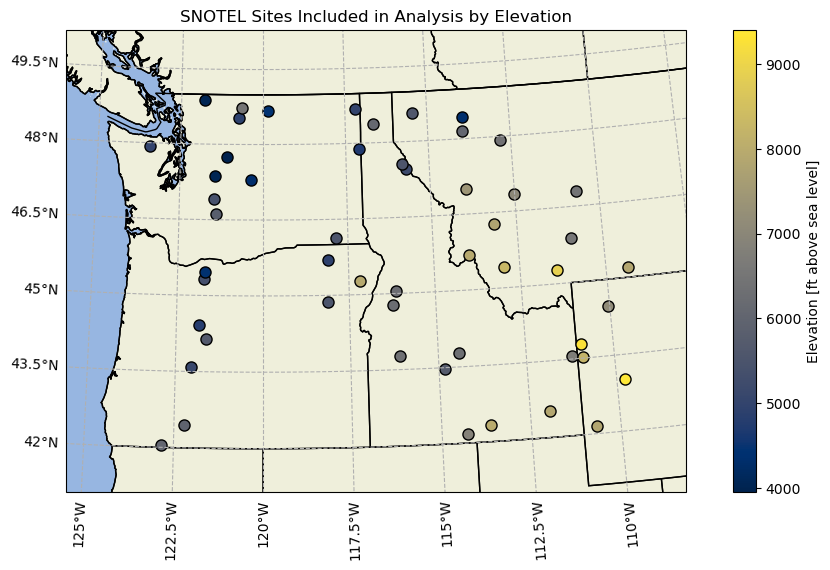

In [27]:
import cartopy.mpl.gridliner as gridliner

# Create a map centered around the mean coordinates
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.AlbersEqualArea(central_longitude=-120, central_latitude=47.5))
ax.set_extent([sntls['lon'].min()-2, sntls['lon'].max()+1, sntls['lat'].min()-1, sntls['lat'].max()+1], crs=ccrs.PlateCarree())

# Add the satellite imagery
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)  # Add state boundaries

# Add the points colored by elevation
for idx, row in sntls.iterrows():
    color = matplotlib.colors.to_hex(plt.cm.cividis(norm(row['elev'])))
    ax.plot(row['lon'], row['lat'], marker='o', color=color, markersize=8, mec='k', transform=ccrs.PlateCarree())

# Create a colorbar
sm = plt.cm.ScalarMappable(cmap=plt.cm.cividis, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, orientation='vertical', label='Elevation [ft above sea level]')

# Add x and y ticks for lon and lat
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, ls='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = gridliner.LONGITUDE_FORMATTER
gl.yformatter = gridliner.LATITUDE_FORMATTER

plt.title('SNOTEL Sites Included in Analysis by Elevation')

# Show the map
plt.show()

## Crust summary stats for all sites

In [86]:
# Load the NetCDF files
ds = xr.open_dataset('/home/cdalden/summa_setup/analysis/crust_stats_ski_snotels.nc')
ds


<xarray.Dataset> Size: 195kB
Dimensions:             (site: 53, time: 25, model_run: 3)
Coordinates:
  * time                (time) datetime64[ns] 200B 2000-01-01 ... 2024-01-01
  * model_run           (model_run) <U7 84B 'current' '+2K' '+4K'
  * site                (site) <U17 4kB 'stevenspass' ... 'grandtarghee'
Data variables:
    mean_crusts         (site, time, model_run) float64 32kB ...
    crust_days          (site, time, model_run) float64 32kB ...
    snow_on             (site, time, model_run) float64 32kB ...
    crusts_binary       (site, time, model_run) float64 32kB ...
    isothermal_days     (site, time, model_run) float64 32kB ...
    percent_crust_days  (site, time, model_run) float64 32kB ...

In [107]:
# Calculate 'percent_crust_days' for 'current' and '+2K'
ds['percent_crust_days'] = ds['crusts_binary']/ds['snow_on']*100
# ds_avg_current = ds['percent_crust_days'].sel(model_run='current').mean(dim='time')
# ds_avg_2K = ds['percent_crust_days'].sel(model_run=comparison_run).mean(dim='time')

olallie = ds.sel(site='hartspass')
olallie = olallie.sel(time=olallie['time.year'] > 2023)

olallie.sel(model_run='current').snow_on.values/24

array([256.75])

### Plot sites with colors for binary crusts

/tmp/ipykernel_29894/2810167150.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = matplotlib.cm.get_cmap('PuOr')


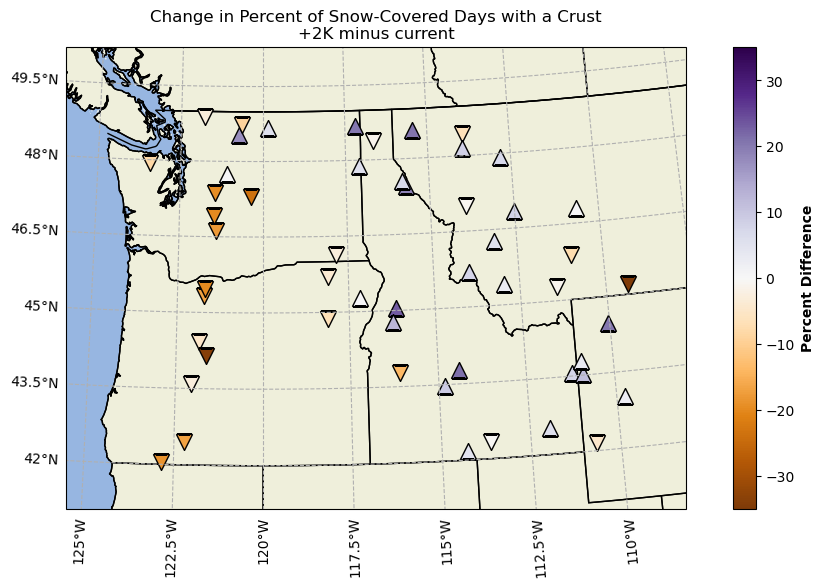

In [102]:
comparison_run = '+2K'

# Calculate 'percent_crust_days' for 'current' and '+2K'
ds['percent_crust_days'] = ds['crusts_binary']/ds['snow_on']*100
ds_avg_current = ds['crusts_binary'].sel(model_run='current').mean(dim='time')/24
ds_avg_2K = ds['crusts_binary'].sel(model_run=comparison_run).mean(dim='time')/24

# Calculate the difference
ds_diff = ds_avg_2K - ds_avg_current

# Ensure ds_diff is an xarray.DataArray
ds_diff = ds_diff.to_dataset(name='percent_crust_days_diff')

# Convert the Dataset to a DataFrame
df_diff = ds_diff.to_dataframe().reset_index()

# Merge the difference DataFrame with the original DataFrame on the site column
df_merged = pd.merge(sntls, df_diff, left_on='site_name', right_on='site', how='inner')  # Use 'inner' join

# Normalize the 'percent_crust_days' column for color mapping
# Normalize the 'percent_crust_days_diff' column for color mapping
norm = matplotlib.colors.Normalize(vmin=df_merged['percent_crust_days_diff'].min(), 
                                   vmax=-df_merged['percent_crust_days_diff'].min())
colormap = matplotlib.cm.get_cmap('PuOr')

# Create a map centered around the mean coordinates
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.AlbersEqualArea(central_longitude=-120, central_latitude=47.5))
ax.set_extent([sntls['lon'].min()-2, sntls['lon'].max()+1, sntls['lat'].min()-1, sntls['lat'].max()+1], crs=ccrs.PlateCarree())

# Add the satellite imagery
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)  # Add state boundaries

# Add the points as arrows
for idx, row in df_merged.iterrows():
    if pd.notna(row['percent_crust_days_diff']):
        color = matplotlib.colors.to_hex(colormap(norm(row['percent_crust_days_diff'])))
        marker = '^' if row['percent_crust_days_diff'] > 0 else 'v'
        # size = np.abs(row['percent_crust_days_diff']) * 0.8  # Adjust the scaling factor as needed
        size = 12
        ax.plot(row['lon'], row['lat'], marker=marker, color=color, markersize=size, markeredgecolor='k', transform=ccrs.PlateCarree())

# Create a colorbar
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
# Create the colorbar and set the label with bold font weight
cbar = fig.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label('Percent Difference', fontweight='bold')

# Add a legend for the arrow sizes
for magnitude in [5, 10, 15, 20]:  # Example magnitudes
    ax.plot([], [], marker='^', color='k', markersize=magnitude * 0.8, label=f'{magnitude}%')

# Add x and y ticks for lon and lat
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, ls='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = gridliner.LONGITUDE_FORMATTER
gl.yformatter = gridliner.LATITUDE_FORMATTER

ax.set_title(f'Change in Percent of Snow-Covered Days with a Crust\n{comparison_run} minus current')

# Show the map
plt.show()

<>:78: SyntaxWarning: invalid escape sequence '\d'
<>:78: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_29894/3091126875.py:78: SyntaxWarning: invalid escape sequence '\d'
  ax.set_title(f'Change in Percent of Snow-Covered Days with a Crust\n+2$\degree$C minus current', fontweight='bold')
/tmp/ipykernel_29894/3091126875.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = matplotlib.cm.get_cmap('coolwarm_r')


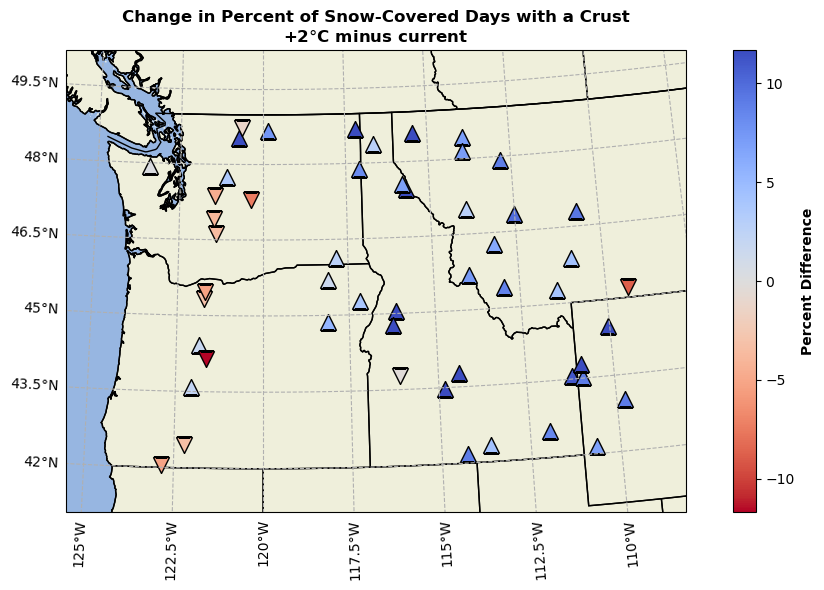

In [30]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# Assuming ds is your xarray Dataset and comparison_run is defined
comparison_run = '+2K'  # Example comparison run

# Calculate 'percent_crust_days' for 'current' and '+2K'
ds['percent_crust_days'] = ds['crusts_binary']/ds['snow_on']*100

# Calculate the average percent crust days for the 'current' and 'comparison_run' model runs
ds_avg_current = ds['percent_crust_days'].sel(model_run='current').mean(dim='time')
ds_avg_comparison = ds['percent_crust_days'].sel(model_run=comparison_run).mean(dim='time')

# Calculate the difference
ds_diff = ds_avg_comparison - ds_avg_current

# Ensure ds_diff is an xarray.DataArray
ds_diff = ds_diff.to_dataset(name='percent_crust_days_diff')

# Convert the Dataset to a DataFrame
df_diff = ds_diff.to_dataframe().reset_index()

# Merge the difference DataFrame with the original DataFrame on the site column
df_merged = pd.merge(sntls, df_diff, left_on='site_name', right_on='site', how='inner')  # Use 'inner' join

# Normalize the 'percent_crust_days_diff' column for color mapping
norm = matplotlib.colors.Normalize(vmin=df_merged['percent_crust_days_diff'].min(), 
                                   vmax=-df_merged['percent_crust_days_diff'].min())
colormap = matplotlib.cm.get_cmap('coolwarm_r')

# Create a map centered around the mean coordinates
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.AlbersEqualArea(central_longitude=-120, central_latitude=47.5))
ax.set_extent([sntls['lon'].min()-2, sntls['lon'].max()+1, sntls['lat'].min()-1, sntls['lat'].max()+1], crs=ccrs.PlateCarree())

# Add the satellite imagery
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)  # Add state boundaries

# Add the points as arrows
for idx, row in df_merged.iterrows():
    if pd.notna(row['percent_crust_days_diff']):
        color = matplotlib.colors.to_hex(colormap(norm(row['percent_crust_days_diff'])))
        marker = '^' if row['percent_crust_days_diff'] > 0 else 'v'
        # size = np.abs(row['percent_crust_days_diff']) * 0.8  # Adjust the scaling factor as needed
        size = 12
        ax.plot(row['lon'], row['lat'], marker=marker, color=color, markersize=size, markeredgecolor='k', transform=ccrs.PlateCarree())

# Create a colorbar
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
# Create the colorbar and set the label with bold font weight
cbar = fig.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label('Percent Difference', fontweight='bold')

# Add a legend for the arrow sizes
for magnitude in [5, 10, 15, 20]:  # Example magnitudes
    ax.plot([], [], marker='^', color='k', markersize=magnitude * 0.8, label=f'{magnitude}%')

# ax.legend(title='Arrow Size Scale', loc='upper right')

# Add x and y ticks for lon and lat
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, ls='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

ax.set_title(f'Change in Percent of Snow-Covered Days with a Crust\n+2$\degree$C minus current', fontweight='bold')

# Show the map
plt.show()

### Plotting change in snow-on days

<>:61: SyntaxWarning: invalid escape sequence '\d'
<>:61: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_29894/3269624858.py:61: SyntaxWarning: invalid escape sequence '\d'
  ax.set_title(f'Percent Change in Snow-Covered Days\n2$\degree$C minus current', fontweight='bold')
/tmp/ipykernel_29894/3269624858.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = matplotlib.cm.get_cmap('afmhot')


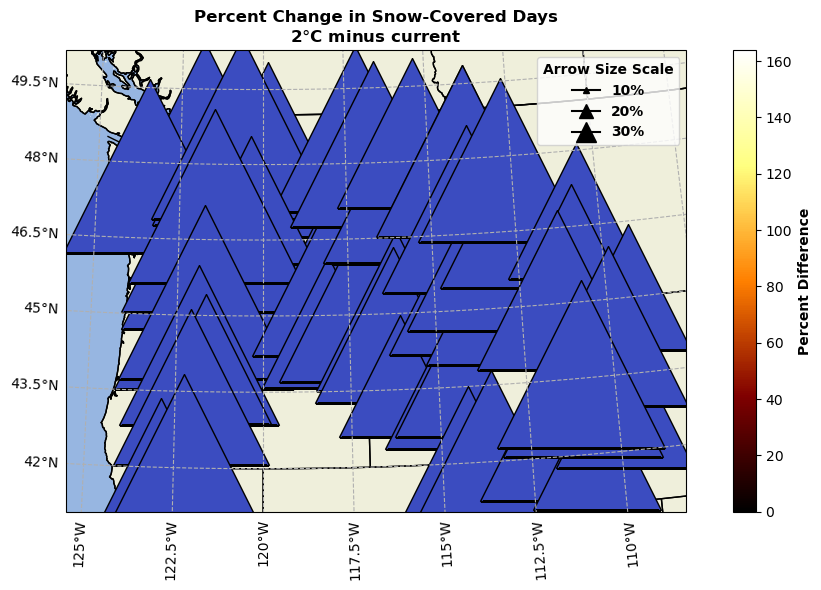

In [31]:
comparison_run = '+2K'

ds_avg_current = ds['snow_on'].sel(model_run='current').mean(dim='time')/24
ds_avg_2K = ds['snow_on'].sel(model_run=comparison_run).mean(dim='time')/24

# Calculate the difference
# ds_diff = ((ds_avg_2K - ds_avg_current)/ds_avg_current)*100
ds_diff = ds_avg_current

# Convert the Dataset to a DataFrame
df_diff = ds_diff.to_dataframe().reset_index()

# Merge the difference DataFrame with the original DataFrame on the site column
df_merged = pd.merge(sntls, df_diff, left_on='site_name', right_on='site', how='inner')  # Use 'inner' join

# Normalize the 'percent_crust_days' column for color mapping
norm = matplotlib.colors.Normalize(vmin=ds_diff.min()-10, vmax=0)
colormap = matplotlib.cm.get_cmap('afmhot')

# Create a map centered around the mean coordinates
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.AlbersEqualArea(central_longitude=-120, central_latitude=47.5))
ax.set_extent([sntls['lon'].min()-2, sntls['lon'].max()+1, sntls['lat'].min()-1, sntls['lat'].max()+1], crs=ccrs.PlateCarree())

# Add the satellite imagery
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)  # Add state boundaries

# Add the points as arrows
for idx, row in df_merged.iterrows():
    if pd.notna(row['snow_on']):
        # color = matplotlib.colors.to_hex(colormap(norm(row['snow_on'])))
        marker = '^' if row['snow_on'] > 0 else 'v'
        size = np.abs(row['snow_on']) * 0.5 # Adjust the scaling factor as needed
        ax.plot(row['lon'], row['lat'], marker=marker, color=color, markersize=size, markeredgecolor='k', transform=ccrs.PlateCarree())

# Create a colorbar
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
# Create the colorbar and set the label with bold font weight
cbar = fig.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label('Percent Difference', fontweight='bold')

# Add a legend for the arrow sizes
for magnitude in [10, 20, 30]:  # Example magnitudes
    ax.plot([], [], marker='^', color='k', markersize=magnitude * 0.5, label=f'{magnitude}%')

# Set the legend with a bold title
ax.legend(title='Arrow Size Scale', loc='upper right', title_fontproperties=bold_font, prop=bold_font)

# Add x and y ticks for lon and lat
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, ls='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = gridliner.LONGITUDE_FORMATTER
gl.yformatter = gridliner.LATITUDE_FORMATTER

ax.set_title(f'Percent Change in Snow-Covered Days\n2$\degree$C minus current', fontweight='bold')

# Show the map
plt.show()

## Plot current snow-on days

/tmp/ipykernel_29894/3583770928.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = matplotlib.cm.get_cmap('spring')


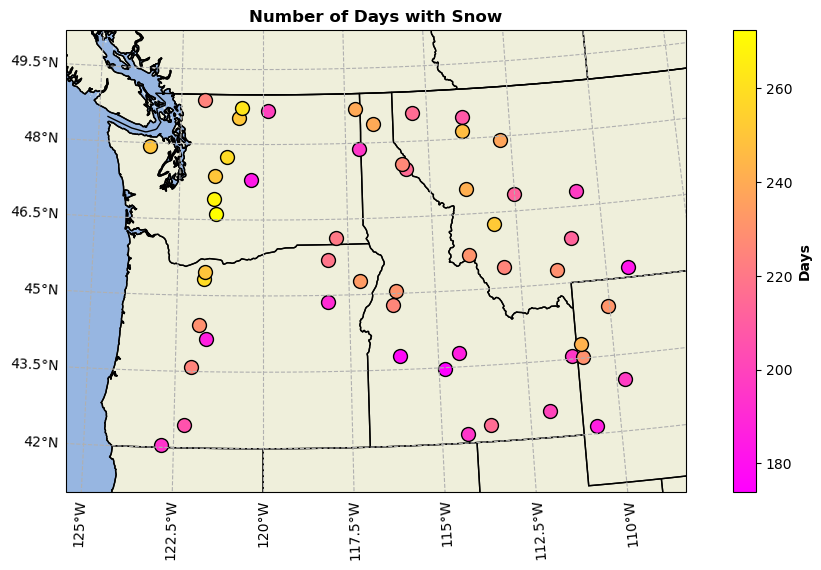

In [32]:
comparison_run = '+2K'

ds_avg_current = ds['snow_on'].sel(model_run='current').mean(dim='time')/24
ds_avg_2K = ds['snow_on'].sel(model_run=comparison_run).mean(dim='time')/24

# Calculate the difference
# ds_diff = ((ds_avg_2K - ds_avg_current)/ds_avg_current)*100
ds_diff = ds_avg_current

# Convert the Dataset to a DataFrame
df_diff = ds_diff.to_dataframe().reset_index()

# Merge the difference DataFrame with the original DataFrame on the site column
df_merged = pd.merge(sntls, df_diff, left_on='site_name', right_on='site', how='inner')  # Use 'inner' join

# Normalize the 'percent_crust_days' column for color mapping
norm = matplotlib.colors.Normalize(vmin=ds_diff.min(), vmax=ds_diff.max())
colormap = matplotlib.cm.get_cmap('spring')

# Create a map centered around the mean coordinates
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.AlbersEqualArea(central_longitude=-120, central_latitude=47.5))
ax.set_extent([sntls['lon'].min()-2, sntls['lon'].max()+1, sntls['lat'].min()-1, sntls['lat'].max()+1], crs=ccrs.PlateCarree())

# Add the satellite imagery
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)  # Add state boundaries

# Add the points as arrows
for idx, row in df_merged.iterrows():
    if pd.notna(row['snow_on']):
        color = matplotlib.colors.to_hex(colormap(norm(row['snow_on'])))
        # marker = '^' if row['snow_on'] > 0 else 'v'
        size = np.abs(row['snow_on']) * 0.5 # Adjust the scaling factor as needed
        ax.plot(row['lon'], row['lat'], marker='o', color=color, markersize=10, markeredgecolor='k', transform=ccrs.PlateCarree())

# Create a colorbar
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
# Create the colorbar and set the label with bold font weight
cbar = fig.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label('Days', fontweight='bold')


# Add x and y ticks for lon and lat
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, ls='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = gridliner.LONGITUDE_FORMATTER
gl.yformatter = gridliner.LATITUDE_FORMATTER

ax.set_title(f'Number of Days with Snow', fontweight='bold')

# Show the map
plt.show()

### Change in isothermal days

<>:63: SyntaxWarning: invalid escape sequence '\d'
<>:63: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_29894/3850642446.py:63: SyntaxWarning: invalid escape sequence '\d'
  ax.set_title(f'Percent Change in Isothermal Days\n2$\degree$C minus current', fontweight='bold')
/tmp/ipykernel_29894/3850642446.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = matplotlib.cm.get_cmap('PuOr')


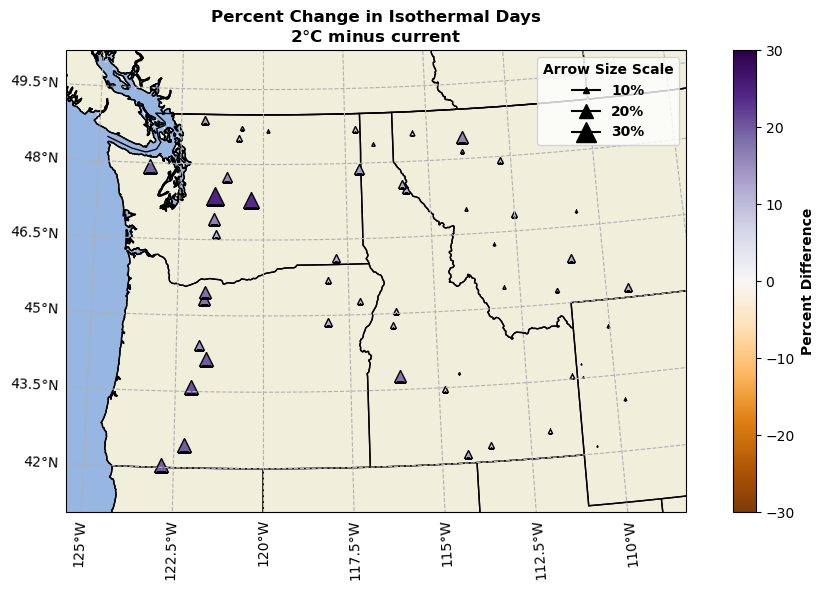

In [33]:
comparison_run = '+2K'

ds['percent_isothermal_days'] = ds['isothermal_days']/ds['snow_on']*100
ds_avg_current = ds['percent_isothermal_days'].sel(model_run='current').mean(dim='time')
ds_avg_2K = ds['percent_isothermal_days'].sel(model_run=comparison_run).mean(dim='time')

# Calculate the difference
ds_diff = ds_avg_2K - ds_avg_current

# Convert the Dataset to a DataFrame
df_diff = ds_diff.to_dataframe().reset_index()

# Merge the difference DataFrame with the original DataFrame on the site column
df_merged = pd.merge(sntls, df_diff, left_on='site_name', right_on='site', how='inner')  # Use 'inner' join

# Normalize the 'percent_crust_days' column for color mapping
norm = matplotlib.colors.Normalize(vmin=-30, vmax=30)
colormap = matplotlib.cm.get_cmap('PuOr')

# Create a map centered around the mean coordinates
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.AlbersEqualArea(central_longitude=-120, central_latitude=47.5))
ax.set_extent([sntls['lon'].min()-2, sntls['lon'].max()+1, 
               sntls['lat'].min()-1, sntls['lat'].max()+1], crs=ccrs.PlateCarree())

# Add the satellite imagery
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)  # Add state boundaries

# Add the points as arrows
for idx, row in df_merged.iterrows():
    if pd.notna(row['percent_isothermal_days']):
        color = matplotlib.colors.to_hex(colormap(norm(row['percent_isothermal_days'])))
        marker = '^' if row['percent_isothermal_days'] > 0 else 'v'
        size = np.abs(row['percent_isothermal_days']) * 0.5 # Adjust the scaling factor as needed
        ax.plot(row['lon'], row['lat'], marker=marker, color=color, markersize=size, 
                markeredgecolor='k', transform=ccrs.PlateCarree())


# Add a legend for the arrow sizes
for magnitude in [10, 20, 30]:  # Example magnitudes
    ax.plot([], [], marker='^', color='k', markersize=magnitude * 0.5, label=f'{magnitude}%')

ax.legend(title='Arrow Size Scale', loc='upper right', title_fontproperties=bold_font, prop=bold_font)

# Create a colorbar
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
# Create the colorbar and set the label with bold font weight
cbar = fig.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label('Percent Difference', fontweight='bold')

# Add x and y ticks for lon and lat
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, ls='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = gridliner.LONGITUDE_FORMATTER
gl.yformatter = gridliner.LATITUDE_FORMATTER

ax.set_title(f'Percent Change in Isothermal Days\n2$\degree$C minus current', fontweight='bold')

# Show the map
plt.show()

### Scatterplot for mean crusts

['current' '+2K' '+4K']


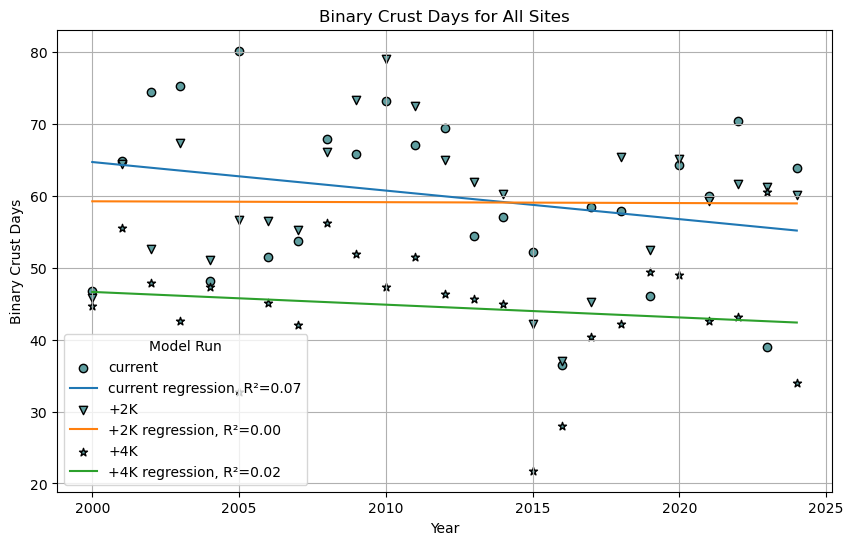

In [34]:
# Define a list of markers
markers = ['o', 'v', '*', '+', 'x', 'D', 'd', '|', '_']

# Average over all sites
ds_avg = ds.mean(dim='site')

# Select only the 'model_run' values 'current', '+2K', and '+4K'
ds_avg = ds_avg.where(ds_avg.model_run.isin(['current', '+2K', '+4K']), drop=True)

# Get the unique 'model_run' values
model_runs = ds_avg.model_run.values
print(model_runs)

# Create a new figure
plt.figure(figsize=(10, 6))

# Loop over the unique 'model_run' values
for i, model_run in enumerate(model_runs):
    # Select the 'mean_crusts' variable for the current 'model_run'
    crust_days = ds_avg['crusts_binary'].sel(model_run=model_run)/24 # will fix later, just to mask snow off for time being

    # Convert the time dimension to years for the x-axis
    years = crust_days.time.dt.year

    # Convert years and crust_days to numpy arrays
    years_np = years.values
    crust_days_np = crust_days.values

    # Remove NaN values
    # mask = ~np.isnan(years_np) & ~np.isnan(crust_days_np)
    mask = ~np.isnan(crust_days_np)
    years_np = years_np[mask]
    crust_days_np = crust_days_np[mask]

    # Check if the arrays are not empty
    if years_np.size > 0 and crust_days_np.size > 0:
        # Plot the data with a different marker for each 'model_run'
        plt.scatter(years_np, crust_days_np, marker=markers[i % len(markers)], label=model_run, color='cadetblue', ec='k')

            # Calculate the coefficients of the linear regression line
        slope, intercept, r_value, p_value, std_err = linregress(years_np, crust_days_np)

                # Calculate R-squared
        r_squared = r_value**2

        # Generate the x values for the regression line
        x = np.linspace(years_np.min(), years_np.max(), 100)

        # Generate the y values for the regression line
        y = slope * x + intercept

        # Plot the regression line
        plt.plot(x, y, label=f'{model_run} regression, R²={r_squared:.2f}')

# Add labels and a legend
plt.xlabel('Year')
plt.ylabel('Binary Crust Days')
plt.title('Binary Crust Days for All Sites')
plt.legend(title='Model Run')
plt.grid(True)

### Percent snow-on days with a crust

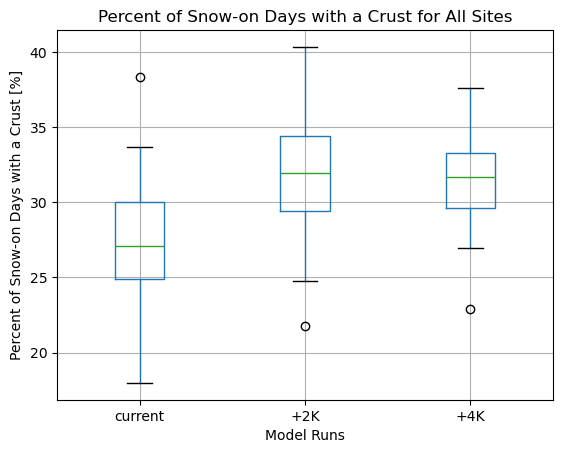

In [35]:
ds_avg['percent_crust_days'] = ds_avg['crusts_binary']/ds_avg['snow_on']*100

# Initialize an empty DataFrame
df = pd.DataFrame()

# Loop over the unique 'model_run' values
for i, model_run in enumerate(model_runs):
    # Select the 'percent_crust_days' variable for the current 'model_run'
    percent_crust_days = ds_avg['percent_crust_days'].sel(model_run=model_run)
    # Add the 'crust_days' values to the DataFrame
    df[model_run] = percent_crust_days

# Create the box and whisker plots
boxplot = df.boxplot(grid=True, vert=True, return_type='dict')

# Add a horizontal line for the mean value of each column
for line, mean in zip(boxplot['medians'], df.mean()):
    line.set_ydata([mean, mean])


# plt.ylim(0, 100)

# Set the labels
plt.ylabel('Percent of Snow-on Days with a Crust [%]')
plt.xlabel('Model Runs')
plt.title(f'Percent of Snow-on Days with a Crust for All Sites')
# plt.title(f'Percent of Snow-on Days with a Crust for Salmon Meadows')


# Show the plot
plt.show()

## Plot mean DJF temperature

In [36]:
sntls = pd.read_csv('/home/cdalden/summa_setup/analysis/sntl_list_ski_temps.csv', index_col=0)


# sntls['mean_temp_djf'] = (sntls['mean_temp_djf'] - 32) * 5.0/9.0

# Convert airtemp to Kelvin
# sntls['mean_temp_djf'] = (1.03*(sntls['mean_temp_djf']-0.9)) # Currier snotel temp correction

<>:27: SyntaxWarning: invalid escape sequence '\c'
<>:27: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_29894/3371556733.py:27: SyntaxWarning: invalid escape sequence '\c'
  cbar.set_label('Temperature [$^\circ$C]', fontweight='bold')
/tmp/ipykernel_29894/3371556733.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = matplotlib.cm.get_cmap('RdBu_r')


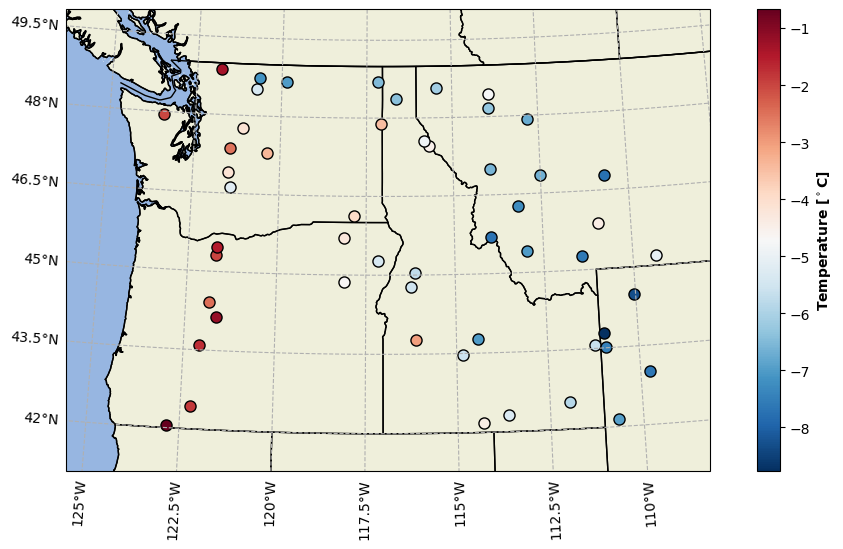

In [37]:
# Normalize the 'percent_crust_days' column for color mapping
norm = matplotlib.colors.Normalize(vmin=sntls['mean_temp_djf'].min(), vmax=sntls['mean_temp_djf'].max())
colormap = matplotlib.cm.get_cmap('RdBu_r')

# Create a map centered around the mean coordinates
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.AlbersEqualArea(central_longitude=-117, central_latitude=45))
ax.set_extent([sntls['lon'].min()-2, sntls['lon'].max()+1, sntls['lat'].min()-1, sntls['lat'].max()+1], crs=ccrs.PlateCarree())

# Add the satellite imagery
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)  # Add state boundaries

# Add the points colored by the difference in 'percent_crust_days'
for idx, row in sntls.iterrows():
    color = matplotlib.colors.to_hex(colormap(norm(row['mean_temp_djf'])))
    ax.plot(row['lon'], row['lat'], marker='o', color=color, markersize=8, markeredgecolor='k', transform=ccrs.PlateCarree())

# Create a colorbar
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
# Create the colorbar and set the label with bold font weight
cbar = fig.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label('Temperature [$^\circ$C]', fontweight='bold')

# Add x and y ticks for lon and lat
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, ls='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = gridliner.LONGITUDE_FORMATTER
gl.yformatter = gridliner.LATITUDE_FORMATTER

# ax.set_title(f'Mean Winter Air Temperature for SNOTELS (DJF)')

# Show the map
plt.show()

### Scatter plot of elevation vs mean DJF temps

<>:5: SyntaxWarning: invalid escape sequence '\d'
<>:7: SyntaxWarning: invalid escape sequence '\d'
<>:5: SyntaxWarning: invalid escape sequence '\d'
<>:7: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_29894/304121506.py:5: SyntaxWarning: invalid escape sequence '\d'
  plt.xlabel('Mean Winter Air Temperature [$ \degree $C]')
/tmp/ipykernel_29894/304121506.py:7: SyntaxWarning: invalid escape sequence '\d'
  plt.colorbar(label='Mean Winter Air Temperature [$ \degree $C]')


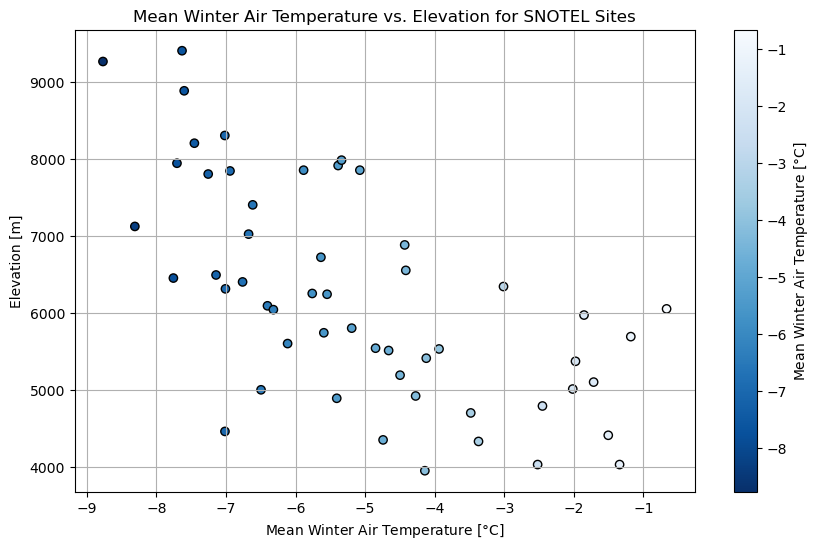

In [38]:
# create a scatter plot of mean_temp_djf vs elevation
plt.figure(figsize=(10, 6))
plt.scatter(sntls['mean_temp_djf'], sntls['elev'], c=sntls['mean_temp_djf'], cmap='Blues_r', edgecolor='k')
plt.ylabel('Elevation [m]')
plt.xlabel('Mean Winter Air Temperature [$ \degree $C]')
plt.title('Mean Winter Air Temperature vs. Elevation for SNOTEL Sites')
plt.colorbar(label='Mean Winter Air Temperature [$ \degree $C]')
plt.grid(True)


## Compare elevation and mean DJF temps to crust stats

In [39]:
# Calculate the average percent isothermal days for the 'current' and '2K' model runs
ds_avg_current = ds['percent_crust_days'].sel(model_run='current').mean(dim='time')
ds_avg_2K = ds['percent_crust_days'].sel(model_run='+2K').mean(dim='time')
ds_avg_4K = ds['percent_crust_days'].sel(model_run='+4K').mean(dim='time')

# Initialize the 'isothermal_days' column in sntls with NaNs
sntls['percent_crust_days_current'] = np.nan
sntls['percent_crust_days_2K'] = np.nan
sntls['percent_crust_days_4K'] = np.nan

# Assign isothermal days to sntls where ds_avg_current.sel(site) matches the sntls['site_name'] column
for idx, row in sntls.iterrows():
    site_name = row['site_name']
    if site_name in ds_avg_current['site']:
        sntls.at[idx, 'percent_crust_days_current'] = ds_avg_current.sel(site=site_name).item()
        sntls.at[idx, 'percent_crust_days_2K'] = ds_avg_2K.sel(site=site_name).item()
        sntls.at[idx, 'percent_crust_days_4K'] = ds_avg_4K.sel(site=site_name).item()





<>:21: SyntaxWarning: invalid escape sequence '\d'
<>:21: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_29894/1272654934.py:21: SyntaxWarning: invalid escape sequence '\d'
  plt.xlabel('Mean Winter Air Temperature [$ \degree $C]')


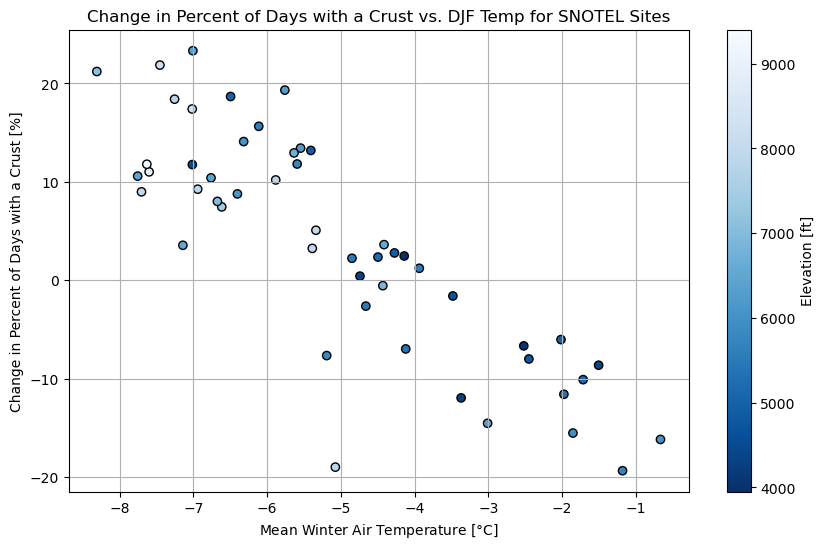

In [40]:
# create a scatter plot of mean_temp_djf vs elevation
plt.figure(figsize=(10, 6))
plt.scatter(sntls['mean_temp_djf'], sntls['percent_crust_days_4K'] - sntls['percent_crust_days_current'], 
            c=sntls['elev'], cmap='Blues_r', edgecolor='k')

    # Calculate the coefficients of the linear regression line
slope, intercept, r_value, p_value, std_err = linregress(sntls['mean_temp_djf'], sntls['percent_crust_days_4K'] - sntls['percent_crust_days_current'])

        # Calculate R-squared
r_squared = r_value**2

# Generate the x values for the regression line
x = np.linspace(sntls['mean_temp_djf'].min(), sntls['mean_temp_djf'].max(), 100)

# Generate the y values for the regression line
y = slope * x + intercept

# Plot the regression line
plt.plot(x, y, label=f'4K regression, R²={r_squared:.2f}')

plt.xlabel('Mean Winter Air Temperature [$ \degree $C]')
plt.ylabel('Change in Percent of Days with a Crust [%]')
plt.title('Change in Percent of Days with a Crust vs. DJF Temp for SNOTEL Sites')
plt.colorbar(label='Elevation [ft]')
plt.grid(True)

/tmp/ipykernel_29894/3962158780.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['percent_crust_days_dif_2K'] = filtered_data['percent_crust_days_dif_2K'].clip(upper=20)


Slope: -2.3632707667787836, Intercept: -6.860409785737616, R-value: -0.662451360898135, P-value: 8.833834875492951e-08, Std Err: 0.3779350222085084


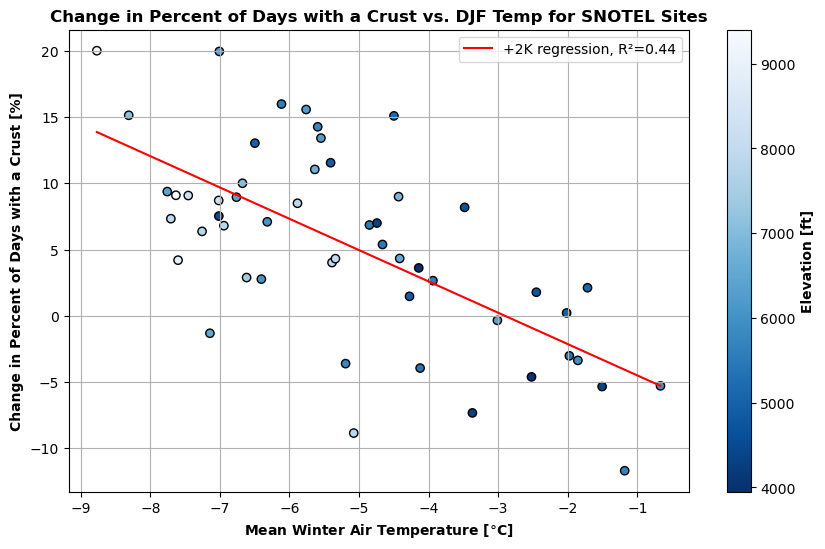

In [48]:

# Assuming sntls is your DataFrame and model_run is defined
model_run = '+2K'  # Example model run

sntls['percent_crust_days_dif_2K'] = sntls['percent_crust_days_2K'] - sntls['percent_crust_days_current']
sntls['percent_crust_days_dif_4K'] = sntls['percent_crust_days_4K'] - sntls['percent_crust_days_current']


# Filter out rows with NaNs in the relevant columns
filtered_data = sntls.dropna(subset=['mean_temp_djf', 'percent_crust_days_dif_2K', 'percent_crust_days_dif_4K'])

# clip percent_crust_days_dif_2K to have max of 100
filtered_data['percent_crust_days_dif_2K'] = filtered_data['percent_crust_days_dif_2K'].clip(upper=20)



# Check if filtered_data is empty
if filtered_data.empty:
    print("Filtered data is empty. No valid data points for regression.")
else:
    # Create a scatter plot of mean_temp_djf vs elevation
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(filtered_data['mean_temp_djf'], filtered_data['percent_crust_days_dif_2K'], 
                c=filtered_data['elev'], cmap='Blues_r', edgecolor='k')

    # Calculate the coefficients of the linear regression line
    slope, intercept, r_value, p_value, std_err = linregress(filtered_data['mean_temp_djf'], filtered_data['percent_crust_days_dif_2K'])

    # Debug: Print the results of the linear regression
    print(f"Slope: {slope}, Intercept: {intercept}, R-value: {r_value}, P-value: {p_value}, Std Err: {std_err}")

    # Calculate R-squared
    r_squared = r_value**2

    # Generate the x values for the regression line
    x = np.linspace(filtered_data['mean_temp_djf'].min(), filtered_data['mean_temp_djf'].max(), 100)

    # Generate the y values for the regression line
    y = slope * x + intercept

    # Create a FontProperties object with bold font weight
    bold_font = FontProperties(weight='bold')
    # Define the font dictionary for bold text
    fontdict_bold = {'weight': 'bold'}

    # Plot the regression line with a bold label
    plt.plot(x, y, label=f'{model_run} regression, R²={r_squared:.2f}', color='red')
    plt.legend(prop=bold_font)  # Set the legend font properties to bold

    plt.xlabel(r'Mean Winter Air Temperature [$ \degree $C]', fontweight='bold')
    plt.ylabel('Change in Percent of Days with a Crust [%]', fontweight='bold')
    plt.title('Change in Percent of Days with a Crust vs. DJF Temp for SNOTEL Sites', fontweight='bold')
    cbar = plt.colorbar(scatter)
    cbar.set_label('Elevation [ft]', fontweight='bold')
    plt.grid(True)
    plt.legend()  # Add legend to display the regression line label
    plt.show()

In [53]:
sntls['percent_crust_days_4K'] - sntls['percent_crust_days_current']

# drop inf values
sntls = sntls.replace([np.inf, -np.inf], np.nan)

Unnamed: 0
0           NaN
1     -6.012416
2      2.477393
3     11.758152
4     13.194960
5      3.565359
6     18.672802
7     -1.582107
8      1.229490
9     -7.636292
10    -6.959626
11   -11.932893
12    -6.650848
13   -11.566506
14    -8.614919
15    -7.979110
16   -19.328793
17   -10.080528
18   -16.151423
19   -15.502040
20     2.787580
21    -2.611461
22     3.250932
23     8.783413
24     2.369749
25     2.246079
26    19.324267
27    13.432691
28   -14.510748
29    11.819033
30    23.322424
31    -0.535462
32     5.091598
33    10.199430
34    12.945093
35    15.645707
36     0.431677
37    14.097636
38     8.994156
39    17.404279
40     7.465151
41    18.401467
42     8.022212
43    10.411412
44    10.588143
45     3.631921
46    11.022100
47   -18.962565
48     9.261400
49    11.794881
50    21.211237
51    21.865605
52          inf
dtype: float64

<>:44: SyntaxWarning: invalid escape sequence '\d'
<>:44: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_29894/658706993.py:44: SyntaxWarning: invalid escape sequence '\d'
  plt.xlabel('Mean Winter Air Temperature [$ \degree $C]', fontweight='bold')
/tmp/ipykernel_29894/658706993.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['percent_crust_days_dif_2K'] = filtered_data['percent_crust_days_dif_2K'].clip(upper=20)
/tmp/ipykernel_29894/658706993.py:42: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(filtered_data['mean_temp_djf'], predictions, label='Predicted', co

Coefficients: [-5.43177223e+00 -1.56365407e-03]
Intercept: -14.170831417279672
R-squared: 0.7271031741197655


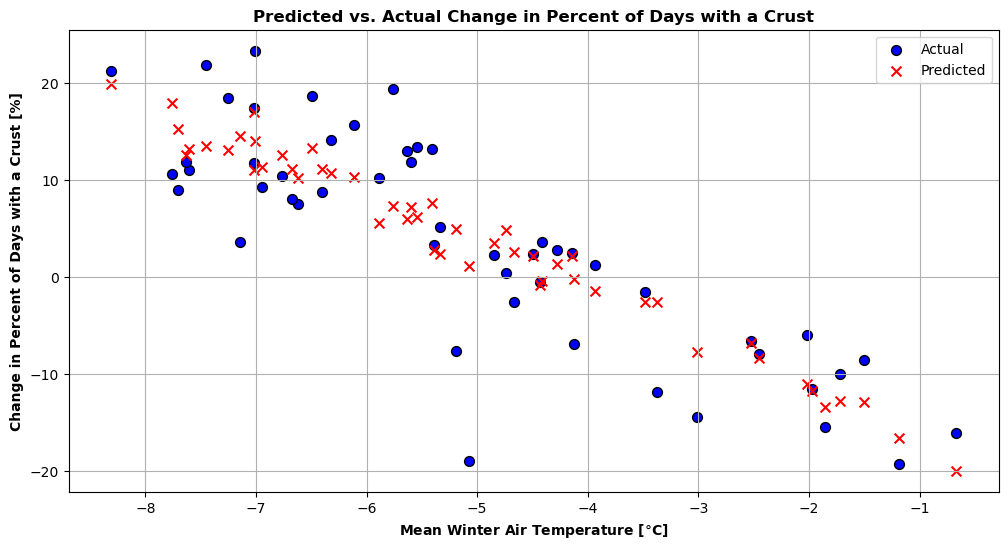

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

# Assuming sntls is your DataFrame and model_run is defined
model_run = '+2K'  # Example model run

sntls = sntls.replace([np.inf, -np.inf], np.nan)
sntls['percent_crust_days_dif_2K'] = sntls['percent_crust_days_2K'] - sntls['percent_crust_days_current']
sntls['percent_crust_days_dif_4K'] = sntls['percent_crust_days_4K'] - sntls['percent_crust_days_current']

# Filter out rows with NaNs in the relevant columns
filtered_data = sntls.dropna(subset=['mean_temp_djf', 'percent_crust_days_dif_2K', 'percent_crust_days_dif_4K'])

# Clip percent_crust_days_dif_2K to have max of 20
filtered_data['percent_crust_days_dif_2K'] = filtered_data['percent_crust_days_dif_2K'].clip(upper=20)

# Check if filtered_data is empty
if filtered_data.empty:
    print("Filtered data is empty. No valid data points for regression.")
else:
    # Prepare the data for multiple linear regression
    X = filtered_data[['mean_temp_djf', 'elev']]
    y = filtered_data['percent_crust_days_dif_4K']

    # Fit the multiple linear regression model
    model = LinearRegression()
    model.fit(X, y)

    # Make predictions
    predictions = model.predict(X)

    # Print the coefficients
    print(f"Coefficients: {model.coef_}")
    print(f"Intercept: {model.intercept_}")
    print(f"R-squared: {model.score(X, y)}")

    # Plot the predictions vs. actual values
    plt.figure(figsize=(12, 6))
    plt.scatter(filtered_data['mean_temp_djf'], y, label='Actual', color='blue', edgecolor='k', s=50)
    plt.scatter(filtered_data['mean_temp_djf'], predictions, label='Predicted', color='red', edgecolor='k', s=50, marker='x')
    
    plt.xlabel('Mean Winter Air Temperature [$ \degree $C]', fontweight='bold')
    plt.ylabel('Change in Percent of Days with a Crust [%]', fontweight='bold')
    plt.title('Predicted vs. Actual Change in Percent of Days with a Crust', fontweight='bold')
    plt.legend()
    plt.grid(True)
    plt.show()

Coefficients: [-2.80515387e+00 -1.41063879e-03]
Intercept: -0.494849530688243
R-squared: 0.4520974874167776


/tmp/ipykernel_29894/3876255938.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['percent_crust_days_dif_2K'] = filtered_data['percent_crust_days_dif_2K'].clip(upper=20)
/tmp/ipykernel_29894/3876255938.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.replace([np.inf, -np.inf], np.nan, inplace=True)


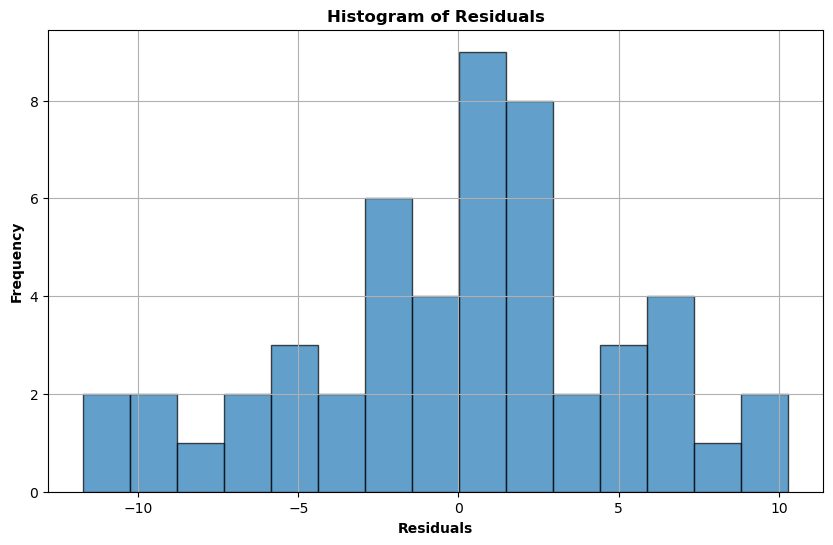

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

# Assuming sntls is your DataFrame and model_run is defined
model_run = '+2K'  # Example model run

sntls['percent_crust_days_dif_2K'] = sntls['percent_crust_days_2K'] - sntls['percent_crust_days_current']
sntls['percent_crust_days_dif_4K'] = sntls['percent_crust_days_4K'] - sntls['percent_crust_days_current']

# Filter out rows with NaNs in the relevant columns
filtered_data = sntls.dropna(subset=['mean_temp_djf', 'percent_crust_days_dif_2K', 'percent_crust_days_dif_4K'])

# Clip percent_crust_days_dif_2K to have max of 20
filtered_data['percent_crust_days_dif_2K'] = filtered_data['percent_crust_days_dif_2K'].clip(upper=20)

# Replace inf and -inf with NaN
filtered_data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN values
# filtered_data.dropna(inplace=True)

# Check if filtered_data is empty
if filtered_data.empty:
    print("Filtered data is empty. No valid data points for regression.")
else:
    # Prepare the data for multiple linear regression
    X = filtered_data[['mean_temp_djf', 'elev']]
    y = filtered_data['percent_crust_days_dif_2K']

    # Fit the multiple linear regression model
    model = LinearRegression()
    model.fit(X, y)

    # Make predictions
    predictions = model.predict(X)

    # Calculate residuals
    residuals = y - predictions

    # Print the coefficients
    print(f"Coefficients: {model.coef_}")
    print(f"Intercept: {model.intercept_}")
    print(f"R-squared: {model.score(X, y)}")

    # Plot the histogram of residuals
    plt.figure(figsize=(10, 6))
    plt.hist(residuals, bins=15, edgecolor='k', alpha=0.7)
    plt.xlabel('Residuals', fontweight='bold')
    plt.ylabel('Frequency', fontweight='bold')
    plt.title('Histogram of Residuals', fontweight='bold')
    plt.grid(True)
    plt.show()

## Linear Regression for Change in Snow-on Days

In [43]:
# Calculate the average percent isothermal days for the 'current' and '2K' model runs
ds_avg_current = ds['percent_isothermal_days'].sel(model_run='current').mean(dim='time')
ds_avg_2K = ds['percent_isothermal_days'].sel(model_run='+2K').mean(dim='time')
ds_avg_4K = ds['percent_isothermal_days'].sel(model_run='+4K').mean(dim='time')

# Initialize the 'isothermal_days' column in sntls with NaNs
sntls['percent_isothermal_days_current'] = np.nan
sntls['percent_isothermal_days_2K'] = np.nan
sntls['percent_isothermal_days_4K'] = np.nan

# Assign isothermal days to sntls where ds_avg_current.sel(site) matches the sntls['site_name'] column
for idx, row in sntls.iterrows():
    site_name = row['site_name']
    if site_name in ds_avg_current['site']:
        sntls.at[idx, 'percent_isothermal_days_current'] = ds_avg_current.sel(site=site_name).item()
        sntls.at[idx, 'percent_isothermal_days_2K'] = ds_avg_2K.sel(site=site_name).item()
        sntls.at[idx, 'percent_isothermal_days_4K'] = ds_avg_4K.sel(site=site_name).item()


<>:28: SyntaxWarning: invalid escape sequence '\d'
<>:28: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_29894/3206516054.py:28: SyntaxWarning: invalid escape sequence '\d'
  plt.xlabel('Mean Winter Air Temperature [$ \degree $C]')


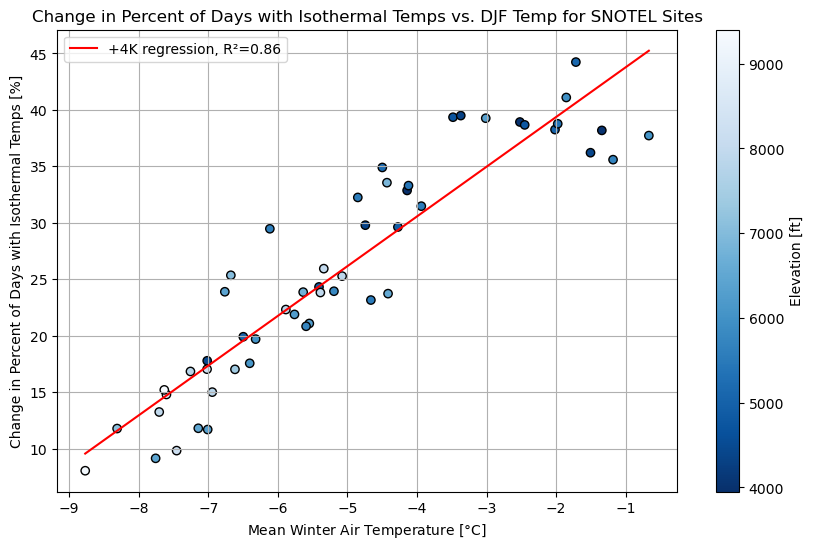

In [44]:
# Assuming sntls is your DataFrame and model_run is defined
model_run = '+4K'  # Example model run

# Filter out rows with NaNs in the relevant columns
filtered_data = sntls.dropna(subset=['mean_temp_djf', 'percent_isothermal_days_4K', 'percent_isothermal_days_current'])

# Create a scatter plot of mean_temp_djf vs elevation
plt.figure(figsize=(10, 6))
plt.scatter(filtered_data['mean_temp_djf'], filtered_data['percent_isothermal_days_4K'] - filtered_data['percent_isothermal_days_current'], 
            c=filtered_data['elev'], cmap='Blues_r', edgecolor='k')

# Calculate the coefficients of the linear regression line
slope, intercept, r_value, p_value, std_err = linregress(filtered_data['mean_temp_djf'], 
                                                         filtered_data['percent_isothermal_days_4K'] - filtered_data['percent_isothermal_days_current'])

# Calculate R-squared
r_squared = r_value**2

# Generate the x values for the regression line
x = np.linspace(filtered_data['mean_temp_djf'].min(), filtered_data['mean_temp_djf'].max(), 100)

# Generate the y values for the regression line
y = slope * x + intercept

# Plot the regression line
plt.plot(x, y, label=f'{model_run} regression, R²={r_squared:.2f}', color='red')

plt.xlabel('Mean Winter Air Temperature [$ \degree $C]')
plt.ylabel('Change in Percent of Days with Isothermal Temps [%]')
plt.title('Change in Percent of Days with Isothermal Temps vs. DJF Temp for SNOTEL Sites')
plt.colorbar(label='Elevation [ft]')
plt.grid(True)
plt.legend()  # Add legend to display the regression line label
plt.show()